In [7]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plot
import statsmodels.api as sm

In [2]:
data = np.loadtxt("data.txt")
data = np.concatenate(data)

# 1. sample characteristics

In [16]:
mean = np.mean(data)
var = np.var(data)
kurtosis = stat.kurtosis(data)
skewness = stat.skew(data)
n = np.size(data)

print(f"mean: {mean}")
print(f"variation: {var}")
print(f"kurtosis: {kurtosis}")
print(f"skewness: {skewness}")
print(f"size: {n}")


mean: -1.100377148133333
variation: 1.8506794964312567
kurtosis: -0.6238925605364338
skewness: -0.21527923156203657
size: 60


# 2. histogramm and sample cdf

(array([ 4.,  2., 10.,  6.,  6., 10., 10.,  8.,  3.,  1.]),
 array([-3.969549  , -3.38107839, -2.79260778, -2.20413717, -1.61566656,
        -1.02719595, -0.43872534,  0.14974527,  0.73821588,  1.32668649,
         1.9151571 ]),
 <BarContainer object of 10 artists>)

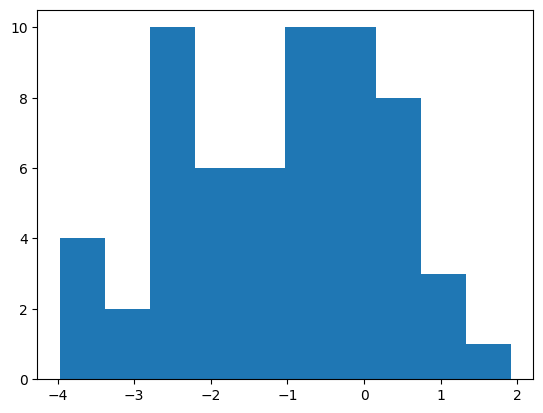

In [5]:
plot.hist(data)

Text(0.5, 1.0, 'empirical cdf')

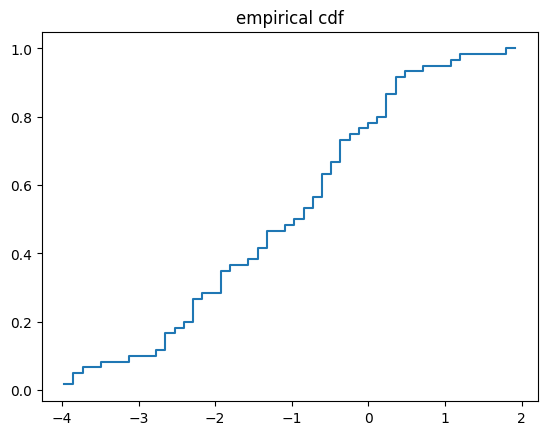

In [11]:
ecdf = sm.distributions.ECDF(data)
x = np.linspace(min(data), max(data))
y = ecdf(x)
plot.step(x, y)
plot.title("empirical cdf")

# 3. gamma confidence interval for edf

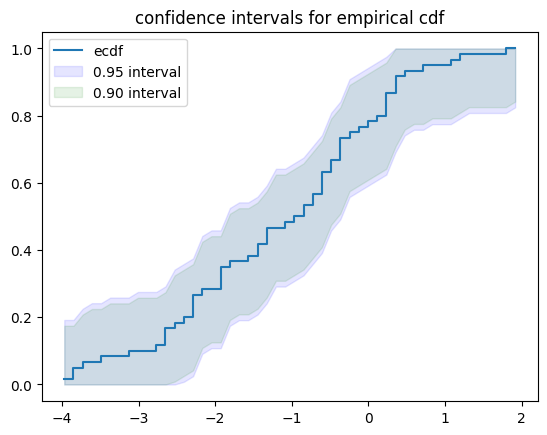

In [46]:
lower_bound = lambda x, perc: ecdf(x) - stat.kstwobign.ppf(perc) / n**0.5
upper_bound = lambda x, perc: ecdf(x) + stat.kstwobign.ppf(perc) / n**0.5


x = np.linspace(min(data), max(data))
y = ecdf(x)
lb_95 = np.maximum(lower_bound(x, 0.95), np.zeros(np.size(x)))
ub_95 = np.minimum(upper_bound(x, 0.95), np.ones(np.size(x)))
lb_90 = np.maximum(lower_bound(x, 0.90), np.zeros(np.size(x)))
ub_90 = np.minimum(upper_bound(x, 0.90), np.ones(np.size(x)))


fig, ax = plot.subplots()
ax.step(x,y)
ax.fill_between(x, lb_95, ub_95, color='b', alpha=.1)
ax.fill_between(x, lb_90, ub_90, color='g', alpha=.1)
plot.title("confidence intervals for empirical cdf")
plot.legend(["ecdf", "0.95 interval", "0.90 interval"])

# 4. 

2